In [ ]:
%pip install pgmpy
%pip install pyitlib

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops, array_ops
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.activations import softmax
class softmax_weight(Constraint):
    """Constrains weight tensors to be under softmax `."""
  
    def __init__(self,feature_uniques):
        idxs = math_ops.cumsum([0] + feature_uniques)
        idxs = [i.numpy() for i in idxs]
        self.feature_idxs = [
            (idxs[i],idxs[i+1]) for i in range(len(idxs)-1)
        ]
  
    def __call__(self, w):     
        w_new = [
            math_ops.log(softmax(w[i:j,:], axis=0))
            for i,j in self.feature_idxs
        ]
        return tf.concat(w_new, 0)
  
    def get_config(self):
        return {'feature_idxs': self.feature_idxs}

In [16]:
def sample(*arrays, size=None, frac=None):
    '''
    random sample from arrays.
    
    Note: arrays must be equal-length
    
    size = None (default) indicate that return a permutation of given arrays.
    '''
    if len(arrays) < 1:
        return None
    if frac is not None and frac <= 1 and frac > 0:
        size = int(len(arrays[0]) * frac)
    if size is None:
        size = len(arrays[0])
        
    random_idxs = np.random.permutation(len(arrays[0]))[:size]
    results = []
    for arr in arrays:
        results.append(arr[random_idxs])
    return results

# GANBLR

In [17]:
def elr_loss(KL_LOSS):
  def loss(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)+ KL_LOSS
  return loss

In [54]:
#from tensorflow.keras.layers import Concatenate
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
class GANBLR:
    def __init__(self, log=True):
        self.g = None
        self.d = None
        self.log = log
        self.g_history = []
        self.d_history = []
        
        self.batch_size = 32 # default value
        self.feature_uniques = []
        self.class_unique = 0
        self.g_input_dim = 0
        self.d_input_dim = 0
        self.y_counts = []
    
    def generate(self, size=None, ohe=False):
        from pgmpy.models import NaiveBayes
        from pgmpy.sampling import BayesianModelSampling
        from pgmpy.factors.discrete import TabularCPD
        #basic varibles
        weights = self.g.get_weights()[0]
        n_features = len(self.feature_uniques)
        n_classes = weights.shape[1]
        n_samples = np.sum(self.class_counts)
        #cut weights by feature uniques
        idxs = np.cumsum([0] + self.feature_uniques)
        feature_idxs  = [(idxs[i],idxs[i+1]) for i in range(len(idxs)-1)]
        feature_names = [str(i) for i in range(n_features)]
        #get cpd of features
        feature_probs = np.exp(weights)
        feature_cpd_probs = [feature_probs[start:end,:] for start, end in feature_idxs]
        feature_cpd_probs = [p/p.sum(axis=0,keepdims=1) for p in feature_cpd_probs]
        feature_cpds = [
            TabularCPD(name, n_unique, table, evidence=['y'], evidence_card=[n_classes])
            for name, n_unique, table in zip(feature_names, self.feature_uniques, feature_cpd_probs)
        ]
        #get cpd of label
        y_probs = (self.class_counts/n_samples).reshape(-1,1)
        y_cpd = TabularCPD('y', n_classes, y_probs)
    
        #define the model
        elr = NaiveBayes(feature_names, 'y')
        elr.add_cpds(y_cpd, *feature_cpds)
        #sampling
        sample_size = n_samples if size is None else size
        result = BayesianModelSampling(elr).forward_sample(size=sample_size)
        sorted_result = result[feature_names + ['y']].values
        #return
        syn_X, syn_y = sorted_result[:,:-1], sorted_result[:,-1]
    
        if ohe:
            ohe_syn_X = [np.eye(b)[syn_X[:,i]] for i, b in enumerate(self.feature_uniques)]
            ohe_syn_X = np.hstack(ohe_syn_X)
            return ohe_syn_X, syn_y
        else:
            return sorted_result
        
    def fit(self, X, y, epochs
                , batch_size=32, warm_up_epochs=10):

        ohe = OneHotEncoder().fit(X)
        ohe_X = ohe.transform(X).toarray()
        #feature_uniques = [len(np.unique(X[:,i])) for i in range(X.shape[1])]
        self.feature_uniques = [len(c) for c in ohe.categories_]
        y_unique, y_counts = np.unique(y, return_counts=True)
        self.class_unique = len(y_unique)
        self.class_counts = y_counts
        self.g_input_dim = np.sum(self.feature_uniques)
        self.d_input_dim = X.shape[1]
        self.batch_size = batch_size
        self._build_g()
        self._build_d()
        
        #warm up
        self.g.fit(ohe_X, y, epochs=warm_up_epochs, batch_size=batch_size)
        syn_data  = self.generate(size=len(X))
        #real_data = np.concatenate([X, y.reshape(-1,1)], axis=-1)
        for i in range(epochs):
            #prepare data
            real_label = np.ones(len(X))
            syn_label = np.zeros(len(X))
            disc_label = np.concatenate([real_label, syn_label])    
            disc_X = np.vstack([X, syn_data[:,:-1]])    
            disc_X, disc_label = sample(disc_X, disc_label, frac=0.8)
            #train d
            self._train_d(disc_X, disc_label)
            prob_fake = self.d.predict(X)
            ls = np.mean(-np.log(np.subtract(1,prob_fake)))
            #train g
            self._train_g(ohe_X, y, loss=ls)
            syn_data = self.generate(size=len(X))

    def _train_g(self, X, y, epochs=1, loss=None):
        if loss is not None:
            clear_session()
            self._build_g(weights=self.g.get_weights(), loss=loss)
            self._build_d(weights=self.d.get_weights())
            
        history = self.g.fit(X, y, epochs=epochs, batch_size=self.batch_size)
        if self.log:
            self.g_history.append(history.history)
    
    def _train_d(self, X, y, epochs=1):
        history = self.d.fit(X, y, batch_size=self.batch_size, epochs=epochs)      
        if self.log:
            self.d_history.append(history.history)  
            
    def _build_g(self, weights=None, loss=None):
        if loss is None:
            loss = elr_loss(0)
        else:
            loss = elr_loss(loss)
        constraint = softmax_weight(self.feature_uniques)
        g = tf.keras.Sequential()    
        g.add(Dense(self.class_unique, input_dim=self.g_input_dim, activation='softmax',kernel_constraint=constraint))
        g.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
        self.g = g
        
        if weights is not None:
            g.set_weights(weights)
        return g
    
    def _build_d(self, weights=None):
        d = tf.keras.Sequential()
        d.add(Dense(1, input_dim=self.d_input_dim, activation='sigmoid'))
        d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self.d = d
        
        if weights is not None:
            d.set_weights(weights)
        return d

# Test

In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv('adult.csv',dtype='category')
df1 = OrdinalEncoder().fit_transform(df).astype('int')
print(df.shape)
X = df1[:,0:-1]
y = df1[:,-1]  
print(len(np.unique(y)))

(48842, 15)
2


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [57]:
epochs = 50
batch_size = 32

clear_session()
ganblr = GANBLR()
ganblr.fit(X_train, y_train, epochs=epochs, warm_up_epochs=5)

Epoch 1/5
764/764 [==============================] - 1s 1ms/step - loss: 0.4287 - accuracy: 0.7908
Epoch 2/5
764/764 [==============================] - 1s 1ms/step - loss: 0.3163 - accuracy: 0.8580
Epoch 3/5
764/764 [==============================] - 1s 1ms/step - loss: 0.3002 - accuracy: 0.8652
Epoch 4/5
764/764 [==============================] - 1s 1ms/step - loss: 0.2921 - accuracy: 0.8684
Epoch 5/5
764/764 [==============================] - 1s 1ms/step - loss: 0.2872 - accuracy: 0.8696


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.3142 - accuracy: 0.8717


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.9767 - accuracy: 0.8724


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.9983 - accuracy: 0.8736


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.1443 - accuracy: 0.8738


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  5.84it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.7860 - accuracy: 0.8732: 0s -


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.1263 - accuracy: 0.8745


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 4.9310 - accuracy: 0.8737


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.1388 - accuracy: 0.8736


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 5.0372 - accuracy: 0.8748


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.2654 - accuracy: 0.8749


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.0709 - accuracy: 0.8746


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.9736 - accuracy: 0.8742


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.8634 - accuracy: 0.8743


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.1332 - accuracy: 0.8746


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.8822 - accuracy: 0.8746


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  5.04it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.8674 - accuracy: 0.8742


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.3717 - accuracy: 0.8739


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.9856 - accuracy: 0.8741


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.2752 - accuracy: 0.8745


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.8648 - accuracy: 0.8743


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.37it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.1821 - accuracy: 0.8749


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.7648 - accuracy: 0.8743


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.2660 - accuracy: 0.8755


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.36it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 5.0371 - accuracy: 0.8749


Generating for node: 7: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.2078 - accuracy: 0.8744: 0s


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.7983 - accuracy: 0.8747


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.33it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.0899 - accuracy: 0.8749


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.7092 - accuracy: 0.8749


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.9319 - accuracy: 0.8746


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.29it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.1096 - accuracy: 0.8749


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.39it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.4162 - accuracy: 0.8745


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.4820 - accuracy: 0.8747


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.2207 - accuracy: 0.8751


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.2596 - accuracy: 0.8740


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.2640 - accuracy: 0.8743


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s] 


764/764 [==============================] - 2s 2ms/step - loss: 5.2198 - accuracy: 0.8749


Generating for node: 7: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.1233 - accuracy: 0.8752


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 5.3221 - accuracy: 0.8750


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  5.01it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 5.1703 - accuracy: 0.8754: 


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 5.4728 - accuracy: 0.8746


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  5.13it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 5.0584 - accuracy: 0.8747


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 5.2936 - accuracy: 0.8742


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.2234 - accuracy: 0.8749


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.26it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.2795 - accuracy: 0.8752


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.28it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 5.1426 - accuracy: 0.8745


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.31it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 5.2181 - accuracy: 0.8742


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s] 


764/764 [==============================] - 1s 2ms/step - loss: 4.8664 - accuracy: 0.8747


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.28it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.9298 - accuracy: 0.8745


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 4.9629 - accuracy: 0.8749


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.30it/s] 


764/764 [==============================] - 1s 1ms/step - loss: 5.1672 - accuracy: 0.8752


Generating for node: 7: 100%|██████████| 15/15 [00:02<00:00,  6.18it/s] 


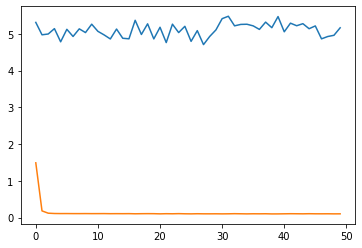

In [60]:
g_loss_log = [d['loss'] for d in ganblr.g_history]
d_loss_log = [d['loss'] for d in ganblr.d_history]

plt.plot(g_loss_log, label='generator loss')
plt.plot(d_loss_log, label='discriminator loss')

In [61]:
ganblr.generate(10)

Generating for node: 7: 100%|██████████| 15/15 [00:00<00:00, 357.10it/s]


array([[10,  6,  0, 11,  5,  0,  3,  4,  4,  1, 13, 20,  3, 31,  0],
       [ 3,  1,  0, 10,  0,  1,  2,  5,  1,  0,  1, 14,  2, 17,  1],
       [ 9,  3,  0,  8,  6,  4, 11,  2,  4,  0,  6,  0,  4, 39,  0],
       [ 1,  1,  0,  1,  1,  3,  7,  0,  2,  1, 13, 13,  3,  9,  0],
       [10,  8,  0,  0,  6,  6,  4,  4,  4,  1, 17,  9,  0, 27,  0],
       [ 9,  0,  0,  2,  0,  3,  8,  4,  4,  0,  8,  9,  3,  7,  0],
       [ 7,  1,  0,  6,  5,  4,  7,  0,  0,  1,  0, 13,  2,  3,  0],
       [ 5,  3,  0,  3,  2,  6,  2,  0,  1,  1, 13, 18,  5, 17,  0],
       [10,  6,  0, 12,  6,  1, 13,  3,  4,  0, 18,  1,  4, 24,  1],
       [ 3,  5,  0, 12,  2,  6,  7,  1,  1,  1,  0, 20,  4, 12,  1]],
      dtype=int64)